<a href="https://colab.research.google.com/github/adithyaac/Captcha-breaker/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

IMAGE_SIZE = (150, 50)
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
MAX_LENGTH = 10
HIDDEN_SIZE = 256

In [2]:
def load_dataset(easy_dir, hard_dir):

    image_paths = []
    words = []

    for directory in [easy_dir, hard_dir]:
        for filename in os.listdir(directory):
            if filename.endswith('.png'):

                image_paths.append(os.path.join(directory, filename))

                word = filename.split('_')[1].split('.')[0]
                words.append(word)

    return image_paths, words

In [3]:
!git clone https://github.com/adithyaac/Captcha-breaker.git

DATASET_PATH = './Captcha-breaker/captcha_dataset'
EASY_DIR = f'{DATASET_PATH}/easy'
HARD_DIR = f'{DATASET_PATH}/hard'



Cloning into 'Captcha-breaker'...
remote: Enumerating objects: 40157, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 40157 (delta 11), reused 1 (delta 1), pack-reused 40128 (from 2)
Receiving objects: 100% (40157/40157), 224.83 MiB | 14.98 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (60002/60002), done.


In [4]:
class CAPTCHADataset(Dataset):

    def __init__(self, image_paths, words, transform=None):

        self.image_paths = image_paths
        self.words = words
        self.transform = transform

        # Create character dictionaries including both cases
        all_chars = set(''.join(words))  # This will now include both upper and lower case
        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
        self.char_to_idx['<PAD>'] = 0  # Add padding token
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}

        print(f"Number of unique characters (including case): {len(all_chars)}")
        print("Character set:", sorted(all_chars))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Convert word to indices, preserving case
        word = self.words[idx]
        word_indices = [self.char_to_idx[c] for c in word]
        # Pad sequence
        word_indices = word_indices + [0] * (MAX_LENGTH - len(word_indices))

        return image, torch.tensor(word_indices), len(word)

In [5]:
class CAPTCHACnnRnn(nn.Module):
    def __init__(self, num_chars, hidden_size=HIDDEN_SIZE):

        super().__init__()

        # CNN Feature Extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
        )

        # Calculate CNN output size
        self.cnn_output_size = 128 * (IMAGE_SIZE[0] // 8) * (IMAGE_SIZE[1] // 8)

        # Linear layer to reduce CNN output size
        self.reduce_dim = nn.Linear(self.cnn_output_size, hidden_size)

        # LSTM layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

        # Output layer
        self.out = nn.Linear(hidden_size, num_chars)

    def forward(self, x):
        # CNN feature extraction
        batch_size = x.size(0)
        x = self.conv_layers(x)
        x = x.view(batch_size, -1)  # Flatten
        x = self.reduce_dim(x)

        # Expand for sequence length
        x = x.unsqueeze(1).repeat(1, MAX_LENGTH, 1)

        # LSTM
        lstm_out, _ = self.lstm(x)

        # Output layer
        output = self.out(lstm_out)
        return output

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for images, labels, lengths in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Reshape outputs and labels for loss calculation
            batch_size, seq_len, num_chars = outputs.size()
            loss = criterion(outputs.view(-1, num_chars), labels.view(-1))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_chars = 0
        total_chars = 0

        with torch.no_grad():
            for images, labels, lengths in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs.view(-1, outputs.size(-1)),
                               labels.view(-1))

                val_loss += loss.item()

                # Calculate character accuracy
                _, predicted = outputs.max(2)
                for pred, label, length in zip(predicted, labels, lengths):
                    correct_chars += (pred[:length] == label[:length]).sum().item()
                    total_chars += length

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct_chars / total_chars * 100

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Character Accuracy: {accuracy:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
image_paths, words = load_dataset(EASY_DIR, HARD_DIR)

train_paths, test_paths, train_words, test_words = train_test_split(
    image_paths, words, test_size=0.2, random_state=42
)
train_paths, val_paths, train_words, val_words = train_test_split(
    train_paths, train_words, test_size=0.2, random_state=42
)

In [17]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])


In [18]:
# Create datasets
train_dataset = CAPTCHADataset(train_paths, train_words, transform)
val_dataset = CAPTCHADataset(val_paths, val_words, transform)
test_dataset = CAPTCHADataset(test_paths, test_words, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of unique characters (including case): 46
Character set: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
Number of unique characters (including case): 46
Character set: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
Number of unique characters (including case): 46
Character set: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [19]:
# Initialize model
num_chars = len(train_dataset.char_to_idx)
model = CAPTCHACnnRnn(num_chars).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore padding
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train model
history = train_model(model, train_loader, val_loader, criterion,
                     optimizer, NUM_EPOCHS, device)

Epoch 1/50:
Train Loss: 2.7723
Val Loss: 2.5085
Character Accuracy: 23.32%
Epoch 2/50:
Train Loss: 2.3613
Val Loss: 2.3116
Character Accuracy: 25.63%
Epoch 3/50:
Train Loss: 2.2251
Val Loss: 2.2315
Character Accuracy: 26.98%
Epoch 4/50:
Train Loss: 2.1317
Val Loss: 2.1451
Character Accuracy: 29.85%
Epoch 5/50:
Train Loss: 2.0395
Val Loss: 2.0849
Character Accuracy: 31.54%
Epoch 6/50:
Train Loss: 1.9442
Val Loss: 1.9981
Character Accuracy: 33.20%
Epoch 7/50:
Train Loss: 1.8542
Val Loss: 1.9178
Character Accuracy: 35.33%
Epoch 8/50:
Train Loss: 1.7466
Val Loss: 1.8293
Character Accuracy: 38.27%
Epoch 9/50:
Train Loss: 1.6439
Val Loss: 1.7590
Character Accuracy: 40.45%
Epoch 10/50:
Train Loss: 1.5325
Val Loss: 1.6611
Character Accuracy: 43.54%
Epoch 11/50:
Train Loss: 1.3983
Val Loss: 1.5450
Character Accuracy: 47.47%
Epoch 12/50:
Train Loss: 1.2116
Val Loss: 1.3575
Character Accuracy: 54.81%
Epoch 13/50:
Train Loss: 0.9469
Val Loss: 1.0853
Character Accuracy: 66.77%
Epoch 14/50:
Train Lo

In [25]:
def compute_char_metrics(model, data_loader, device):
    """Compute character-level accuracy and confusion matrix"""
    correct_chars = 0
    total_chars = 0
    char_errors = []

    model.eval()
    with torch.no_grad():
        for images, labels, lengths in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(2)

            # Calculate character accuracy
            for pred, label, length in zip(predicted, labels, lengths):
                pred_chars = [train_dataset.idx_to_char[idx.item()] for idx in pred[:length]]
                true_chars = [train_dataset.idx_to_char[idx.item()] for idx in label[:length]]

                correct_chars += sum(p == t for p, t in zip(pred_chars, true_chars))
                total_chars += length

                # Record errors
                if pred_chars != true_chars:
                    char_errors.append({
                        'predicted': ''.join(pred_chars),
                        'actual': ''.join(true_chars)
                    })

    accuracy = correct_chars / total_chars * 100
    return accuracy, char_errors

In [26]:
def compute_word_metrics(model, data_loader, device):
    """Compute word-level accuracy and collect examples"""
    correct_words = 0
    total_words = 0
    word_examples = []

    model.eval()
    with torch.no_grad():
        for images, labels, lengths in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(2)

            # Calculate word accuracy
            for pred, label, length in zip(predicted, labels, lengths):
                pred_word = ''.join([train_dataset.idx_to_char[idx.item()]
                                   for idx in pred[:length]])
                true_word = ''.join([train_dataset.idx_to_char[idx.item()]
                                   for idx in label[:length]])

                is_correct = pred_word == true_word
                if is_correct:
                    correct_words += 1

                word_examples.append({
                    'predicted': pred_word,
                    'actual': true_word,
                    'correct': is_correct
                })
                total_words += 1

    accuracy = correct_words / total_words * 100
    return accuracy, word_examples

In [27]:
def analyze_case_errors(word_examples):
    """Analyze case-related errors"""
    case_errors = 0
    total_errors = 0

    for example in word_examples:
        if not example['correct']:
            total_errors += 1
            # Check if error is only due to case
            if example['predicted'].lower() == example['actual'].lower():
                case_errors += 1

    if total_errors > 0:
        case_error_percentage = (case_errors / total_errors) * 100
    else:
        case_error_percentage = 0

    return case_errors, total_errors, case_error_percentage

In [28]:
def visualize_examples(model, data_loader, device, num_examples=5):
    """Visualize some predictions with their images"""
    model.eval()

    examples = []
    with torch.no_grad():
        for images, labels, lengths in data_loader:
            batch_images = images.to(device)
            outputs = model(batch_images)
            _, predicted = outputs.max(2)

            for i in range(len(images)):
                pred_word = ''.join([train_dataset.idx_to_char[idx.item()]
                                   for idx in predicted[i][:lengths[i]]])
                true_word = ''.join([train_dataset.idx_to_char[idx.item()]
                                   for idx in labels[i][:lengths[i]]])

                examples.append({
                    'image': images[i],
                    'predicted': pred_word,
                    'actual': true_word
                })

                if len(examples) >= num_examples:
                    break
            if len(examples) >= num_examples:
                break

    # Plot examples
    fig, axes = plt.subplots(1, num_examples, figsize=(20, 4))
    for i, example in enumerate(examples):
        img = example['image'].permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {example['predicted']}\nTrue: {example['actual']}")
    plt.tight_layout()
    plt.show()

Character-level Accuracy: 89.96%
Word-level Accuracy: 73.91%

Error Analysis:
Total Errors: 2087
Case-only Errors: 601 (28.80%)

Visualizing examples:


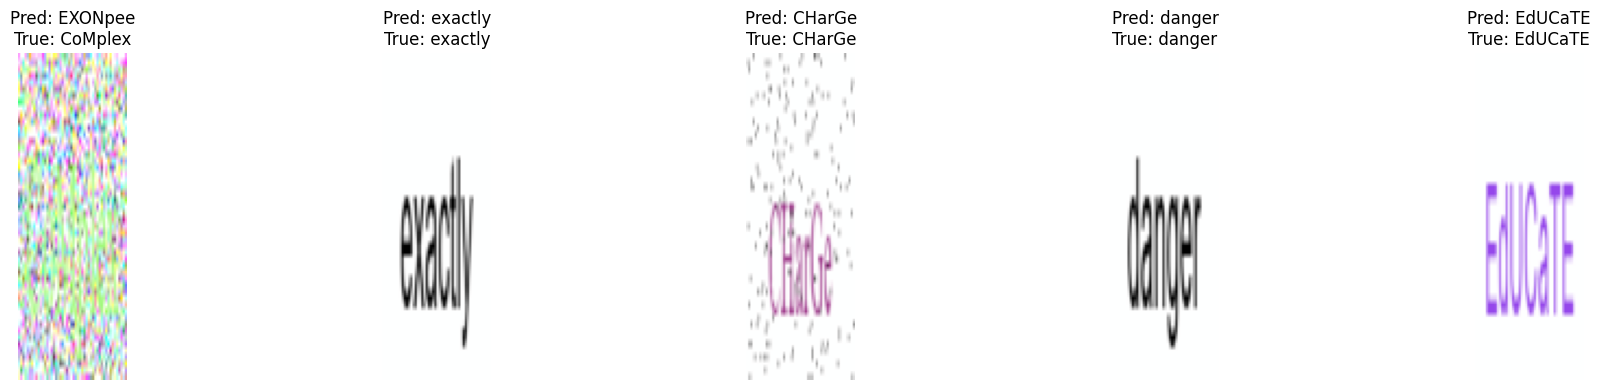

In [29]:
def evaluate_model(model_path, test_loader, device):
    """Complete model evaluation"""

    # Compute metrics
    char_accuracy, char_errors = compute_char_metrics(model, test_loader, device)
    word_accuracy, word_examples = compute_word_metrics(model, test_loader, device)
    case_errors, total_errors, case_error_percentage = analyze_case_errors(word_examples)

    # Print results
    print(f"Character-level Accuracy: {char_accuracy:.2f}%")
    print(f"Word-level Accuracy: {word_accuracy:.2f}%")
    print(f"\nError Analysis:")
    print(f"Total Errors: {total_errors}")
    print(f"Case-only Errors: {case_errors} ({case_error_percentage:.2f}%)")

    # Show some example predictions
    print("\nVisualizing examples:")
    visualize_examples(model, test_loader, device)

    # Print some error examples
    print("\nSome error examples:")
    error_examples = [ex for ex in word_examples if not ex['correct']][:5]
    for ex in error_examples:
        print(f"Predicted: {ex['predicted']}")
        print(f"Actual: {ex['actual']}")
        print("-" * 30)

# Run evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_model('best_model.pth', test_loader, device)